### In this notebook we will learn:

* Getting Data: How to import data from PyCaret repository
* Setting up the sqlite database: To store the model artifacts, it is important to have a persistent database through sqlite.
* Setting up Environment: How to setup an experiment in PyCaret and get started with building classification models
* Create & Compare Models: How to create and compare various models, perform stratified cross validation and evaluate classification metrics
* Predict Model: How to make predictions on new / unseen data

## Loading Data 

### 1.1 Importing packages

In [30]:
import os
import sys

new_directory = r'\\wsl.localhost\Ubuntu\home\charliethomasctg\airflow'
current_directory = os.getcwd()
scripts_path = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

def change_directory(current_directory, new_directory,scripts_path):
    # Get the current working directory
    print(f'Current directory: {current_directory}')
    # Define the path to change to
    new_directory = r'\\wsl.localhost\Ubuntu\home\charliethomasctg\airflow'
    try:
        # Change the current working directory
        os.chdir(new_directory)
        # Verify the change
        current_directory = os.getcwd()
        print(f'Current directory changed to: {current_directory}')
    except FileNotFoundError:
        print(f'Error: The directory "{new_directory}" does not exist.')
    except PermissionError:
        print(f'Error: Permission denied to change to "{new_directory}".')
    except Exception as e:
        print(f'An unexpected error occurred: {e}')
    # Add the scripts directory to the Python path
    sys.path.append(scripts_path)

    
change_directory(current_directory, new_directory, scripts_path)

Current directory: \\wsl.localhost\Ubuntu\home\charliethomasctg\airflow
Current directory changed to: \\wsl.localhost\Ubuntu\home\charliethomasctg\airflow


In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import utils
from pycaret.classification import *
# Other Libraries
import mlflow

In [33]:
# Setting up all directory
root_folder = "/home/charliethomasctg/airflow"
database_path = root_folder+"/database/"
data_directory = root_folder+"/data/raw/"
data_profile_path = root_folder+"/data/profile_report/"
intermediate_data_path = root_folder+"/data/interim/"
final_processed_data_path = root_folder+"/data/processed/"


old_data_directory = root_folder+"/data/raw/"
new_data_directory = root_folder+"/data/new/"
intermediate_path = root_folder+"/data/interim/"

# Database
db_path = root_folder+"/database/"
db_file_name = "feature_store_v01.db"
drfit_db_name = "drift_db_name.db"
date_columns = ['registration_init_time','transaction_date_min','transaction_date_max','membership_expire_date_max','last_login']

 ### 1.2 Reading the merged data

In [34]:
%%time
interim_data = "final_train_data_interim_1728637332.csv" # set the data recieved from the previous notebook
dataset = utils.load_data( [f"{intermediate_data_path}{interim_data}",
                            ]
                         )[0] #since we are only loading single data, we can access it with index 0, since it return multiple dfs in list
dataset.shape

CPU times: total: 500 ms
Wall time: 1.78 s


(324000, 24)

In [35]:
dataset.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn,payment_method_id,payment_plan_days,plan_list_price,...,is_cancel,transaction_date_max,membership_expire_date_max,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,/7XuYVGXYHPggWsdtok0JEurQ10CtUO1Y8dDgy1/B0M=,1,0,others,7,2016-12-23,0,41.0,30.0,149.0,...,0.0,2017-02-22,2017-03-22,0.000000,0.000000,0.0,0.000000,2.289867,2.289867,7.808594
1,gB3/kawEQSauWFArU9Z0kZo+ikw9GqJv0rXqNbpVnTY=,1,0,others,7,2016-12-23,0,41.0,30.0,99.0,...,0.0,2017-02-23,2017-03-23,0.274653,0.000000,0.0,0.000000,2.845647,2.281930,8.363281
2,2aFAPs3QmxD+bNcCe8beuWcI7SZHg1k+1irALOxiw3k=,15,23,female,4,2016-12-24,0,40.0,30.0,149.0,...,0.0,2017-02-27,2017-03-26,0.000000,0.000000,0.0,0.000000,4.708342,4.683700,10.236328
3,FjEZAhwFky8sWoaNGTp+p/r3/hH30WxLr396iSho3gs=,1,0,others,7,2016-12-25,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.621227,0.173287,0.0,0.346574,3.070758,2.640511,8.630859
4,C5PNTuQxUQmHOXPptQnokhqH1XQoAHHL8pMWIX0nAh0=,1,0,others,7,2016-12-25,0,41.0,30.0,99.0,...,0.0,2017-02-24,2017-03-24,0.000000,0.000000,0.0,0.000000,1.595831,1.499937,7.083334


 ### 1.3 Splitting the data to seen and unseen

In [36]:
data_for_model, data_unseen = utils.get_validation_unseen_set(dataset, validation_frac=0.05, sample=True, sample_frac=0.1)
print('Data for Modeling: ' + str(data_for_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (30780, 24)
Unseen Data For Predictions: (1620, 24)


In [37]:
data_for_model.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn,payment_method_id,payment_plan_days,plan_list_price,...,is_cancel,transaction_date_max,membership_expire_date_max,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,0EmgzzU4BjmbS3VcwGYhODEpRFrhWeDxa83ytyxl9PQ=,1,0,others,7,2015-05-24,0,41.000000,30.0,149.000000,...,0.0,2017-02-24,2017-03-24,1.800753,0.743873,0.564219,0.435245,2.399982,3.055098,8.229990
1,Ahb6Op1oSQ/MMk34k+1w0w+XMHE92stp2DpES84rIYM=,1,0,others,7,2015-10-31,0,41.000000,30.0,99.000000,...,0.0,2017-02-28,2017-03-31,0.560319,0.322600,0.000000,0.173287,2.261100,2.392559,7.723307
2,RNzZM0eHKg6/9p8lrNcUlQ1Fav6y4IGIR+TyD98cIqM=,1,0,others,7,2016-07-01,0,41.000000,30.0,99.000000,...,0.0,2017-02-01,2017-03-01,1.146242,0.346574,0.173287,0.549306,2.379456,2.887266,8.231445
3,FVZe4KpHHBOyi9SRRVJmQ9KF21qT569Mds9dQryqhok=,1,0,others,9,2016-02-29,0,28.909091,30.0,149.909091,...,0.0,2017-02-03,2017-03-05,1.936287,0.520237,0.292083,0.115525,2.432663,2.972121,7.998047
4,xB0z2ezAIPyi7eZxYtq1JKMMg/KSavvRqTPKU4TYopA=,1,0,others,7,2015-08-15,0,41.000000,30.0,99.000000,...,0.0,2017-02-15,2017-03-15,0.506885,0.028881,0.086643,0.687113,2.256851,1.277449,7.839030


In [38]:
data_for_model.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'is_churn', 'payment_method_id',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'is_auto_renew', 'transaction_date_min', 'membership_expire_date_min',
       'is_cancel', 'transaction_date_max', 'membership_expire_date_max',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs'],
      dtype='object')

### 2 Setting up the sqlite database

In [40]:
utils.create_sqlit_connection(database_path,r"mlflow_v01.db")
utils.create_sqlit_connection(database_path,r"feature_store_v01.db")
utils.create_sqlit_connection(database_path,r"drift_db_name.db")

2.6.0
2.6.0
2.6.0


In [47]:
import subprocess

subprocess.run([
    'mlflow', 'server',
    '--backend-store-uri', 'sqlite://///home/charliethomasctg/airflow/database/mlflow_v01.db',
    '--default-artifact-root', '/home/charliethomasctg/airflow/mlruns',
    '--port=6006',
    '--host=0.0.0.0'
])


CompletedProcess(args=['mlflow', 'server', '--backend-store-uri', 'sqlite://///home/charliethomasctg/airflow/database/mlflow_v01.db', '--default-artifact-root', '/home/charliethomasctg/airflow/mlruns', '--port=6006', '--host=0.0.0.0'], returncode=1)

In [52]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:6006")


In [42]:
# do not go ahead unless you execute this step and mlflow is isntalled. 
 
#MAKE mlruns FOLDER on root folder
#run this on terminal where you are on root folder. 
# Makse sure to point the database to correct address. Assuming you have same folder structure you can use this

# mlflow server --backend-store-uri sqlite://///home/charliethomasctg/airflow/database/mlflow_v01.db --default-artifact-root /home/charliethomasctg/airflow/mlruns --port=6006 --host=0.0.0.0


In [43]:
#pip install pycaret==2.3.8

### 3 Setting up Environment: 

The `setup()` function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. `setup()`must be called before executing any other function in pycaret. 
* It takes two mandatory parameters: a pandas dataframe and the name of the target column. 
* All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When `setup()` is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [53]:
# List of date columns
date_columns = ['registration_init_time', 'transaction_date_min', 'transaction_date_max', 'membership_expire_date_max']

# Convert to datetime
for col in date_columns:
    data_for_model[col] = pd.to_datetime(data_for_model[col])

In [67]:
# No Pre-Processing 
Baseline_model_exp01 = setup(data = data_for_model, target = 'is_churn', 
                   session_id = 42,fix_imbalance=True,ignore_features=['msno'],
                   date_features=['registration_init_time', 'transaction_date_min', 'transaction_date_max', 'membership_expire_date_max'],
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   verbose=True,
                   log_profile=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

,Description,Value
0,Session id,42
1,Target,is_churn
2,Target type,Binary
3,Original data shape,"(30780, 24)"
4,Transformed data shape,"(49466, 33)"
5,Transformed train set shape,"(40232, 33)"
6,Transformed test set shape,"(9234, 33)"
7,Ignore features,1
8,Numeric features,16
9,Date features,4


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

2024/10/11 11:27:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session Initialized a863 at: http://127.0.0.1:6006/#/experiments/3/runs/460663d624314cb79d41ee06140f6125.
2024/10/11 11:27:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:6006/#/experiments/3.


In [68]:
X_train, y_train, X_test, y_test = utils.get_train_test_set_from_setup()
#you can also get X,y
# X,y = utils.get_x_y_from_setup()
X_train.head()

,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,...,is_cancel,transaction_date_max,membership_expire_date_max,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5488,13,26,male,3,2015-10-20,36.125,30.000000,170.562500,170.562500,0.0,...,0.000000,2017-02-14,2017-03-16,0.991506,0.233268,0.124822,0.161300,2.662653,2.913767,8.268555
29459,1,0,others,7,2015-05-12,41.000,28.695652,142.521744,142.521744,1.0,...,0.086957,2017-02-14,2017-03-14,1.440832,0.798048,0.479447,0.571290,3.389400,3.050168,9.025302
17556,1,0,others,7,2015-09-08,41.000,30.000000,99.000000,99.000000,1.0,...,0.000000,2017-02-07,2017-03-07,2.263562,0.631612,0.536256,0.490902,2.379424,2.686707,8.148995
4483,1,0,others,7,2017-01-09,41.000,30.000000,100.000000,100.000000,1.0,...,0.000000,2017-02-08,2017-03-08,2.532456,0.659764,0.850299,0.722593,1.758377,2.974833,7.857422
26361,1,0,others,7,2016-05-26,41.000,30.000000,149.000000,149.000000,1.0,...,0.000000,2017-02-26,2017-03-26,1.757619,0.580187,0.356389,0.490509,2.310352,3.082538,8.268229


In [69]:
pipeline = utils.get_transformation_pipeline_from_setup()
pipeline

Pipeline(memory=FastMemory(location=C:\Users\44775\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None,
                                    include=['registration_init_time',
                                             'transaction_date_min',
                                             'transaction_date_max',
                                             'membership_expire_date_max'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 Trans...
                                    transformer=TargetEncoder(cols=['membership_expire_date_min'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              hierarchy=None,
                                                              min_samples_leaf=20,
                                                              return_df=True,
                                                              smoothing=10,
                                                              verbose=0))),
                ('balance',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                              n_jobs=None,
                                                                              random_state=42,
                                                                              sampling_strategy='auto'))))],
         verbose=False)

In [70]:
# p = get_config(variable="prep_pipe")
# p.fit_transform(get_config(variable="data_before_preprocess"))

In [71]:
# models(internal=True)[['Name', 'GPU Enabled']]

### 4 Compare models: 

In [72]:
best_model = compare_models(fold = 5) #exclude=['xgboost']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9500,0.9542,0.5350,0.6510,0.5868,0.5605,0.5638,0.9520
rf,Random Forest Classifier,0.9456,0.9411,0.6119,0.5863,0.5986,0.5695,0.5697,1.7660
lightgbm,Light Gradient Boosting Machine,0.9379,0.9226,0.6063,0.5291,0.5645,0.5313,0.5330,2.3740
gbc,Gradient Boosting Classifier,0.9377,0.9332,0.6210,0.5257,0.5694,0.5360,0.5382,14.2440
ridge,Ridge Classifier,0.9354,0.9409,0.7881,0.5086,0.6182,0.5847,0.6015,0.2940
lda,Linear Discriminant Analysis,0.9352,0.9405,0.7853,0.5074,0.6164,0.5828,0.5994,0.3360
nb,Naive Bayes,0.9347,0.9290,0.6042,0.5069,0.5510,0.5161,0.5186,0.3420
dummy,Dummy Classifier,0.9336,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2940
ada,Ada Boost Classifier,0.9329,0.9159,0.5524,0.4985,0.5211,0.4854,0.4877,3.2840
lr,Logistic Regression,0.9315,0.9317,0.7839,0.4901,0.6031,0.5678,0.5866,2.5480


2024/10/11 11:31:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:31:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extra Trees Classifier at: http://127.0.0.1:6006/#/experiments/3/runs/43dd61337c1646588f6bb838cf9cf884.
2024/10/11 11:31:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:6006/#/experiments/3.
2024/10/11 11:31:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:31:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://127.0.0.1:6006/#/experiments/3/runs/755c7e989ea04d0b8ff31065db91a211.
2024/10/11 11:31:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:6006/#/e

* Two simple words of code (not even a line) have created over 15 models using 10 fold stratified cross validation and evaluated the 6 most commonly used classification metrics (Accuracy, AUC, Recall, Precision, F1, Kappa). 

* The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. 

* If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time.

In [73]:
#selecting the best model
lgbm  = create_model('lightgbm', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9355,0.9201,0.5385,0.5133,0.5256,0.4910,0.4912
1,0.9320,0.9153,0.6259,0.4904,0.5499,0.5137,0.5182
2,0.9399,0.9160,0.6154,0.5415,0.5761,0.5439,0.5452
3,0.9415,0.9306,0.6154,0.5535,0.5828,0.5514,0.5523
4,0.9408,0.9308,0.6364,0.5465,0.5880,0.5564,0.5582
Mean,0.9379,0.9226,0.6063,0.5291,0.5645,0.5313,0.5330
Std,0.0036,0.0068,0.0348,0.0237,0.0234,0.0250,0.0250


2024/10/11 11:32:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:32:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://127.0.0.1:6006/#/experiments/3/runs/d2d86c46fbd043ffbe21aca16b7dc09f.
2024/10/11 11:32:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:6006/#/experiments/3.


In [74]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### 5 Analyzing the model performance

5.1 Learning Curve

In [75]:
%matplotlib inline

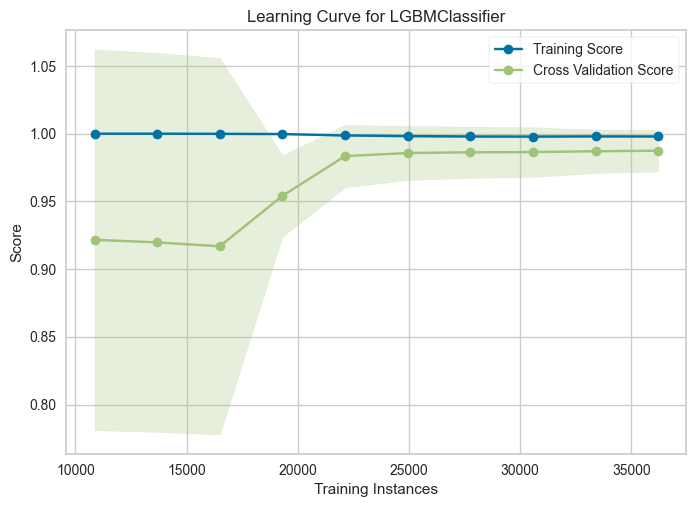

In [76]:
plot_model(lgbm, plot = 'learning')

5.2 ROC Curve

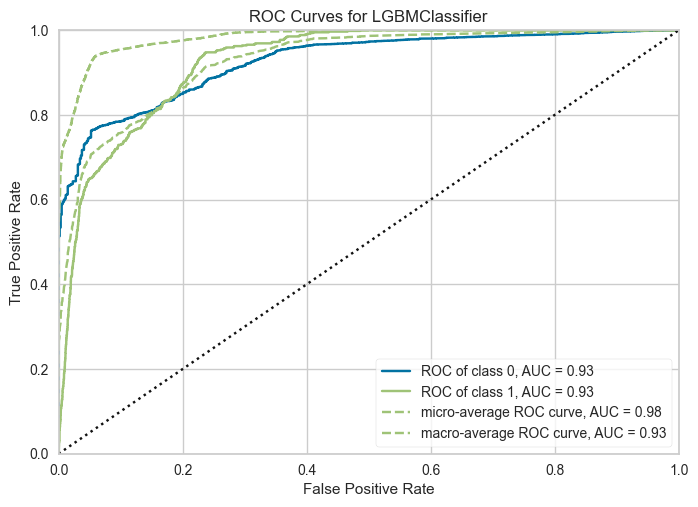

In [77]:
plot_model(lgbm, plot = 'auc')

5.3 Precision-recall Curve

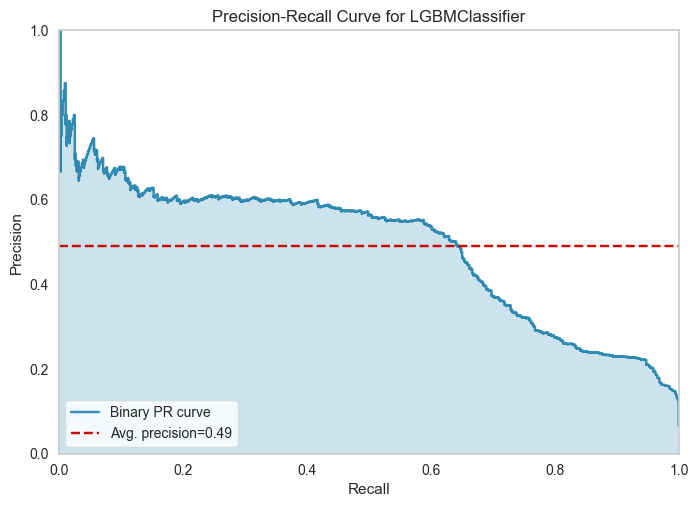

In [78]:
plot_model(lgbm, plot = 'pr')

5.4 Confusion Matrix

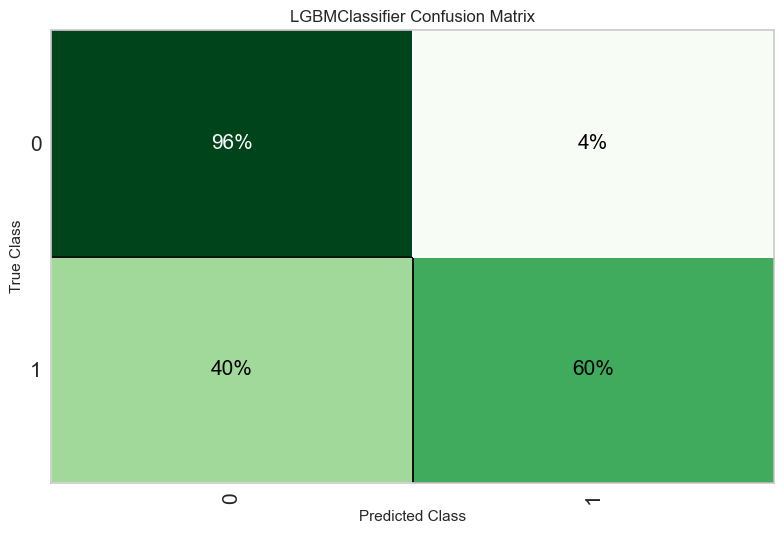

In [79]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

5.5 Feature Importance

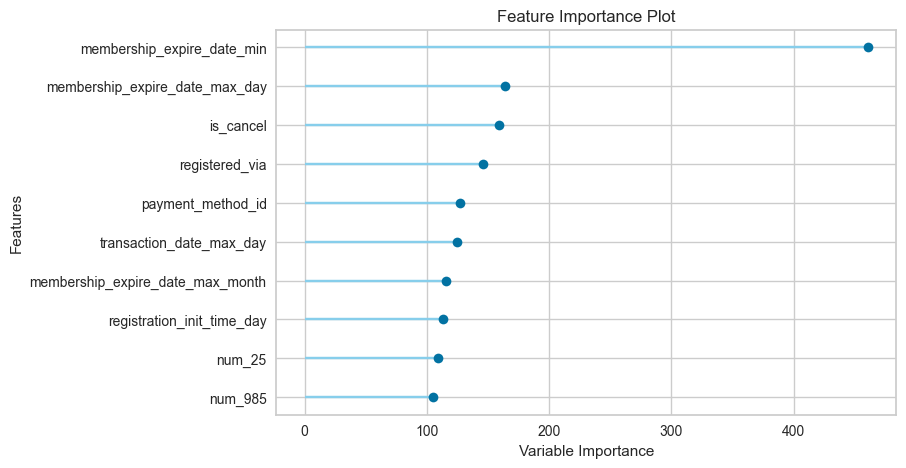

In [80]:
#top 10 features
plot_model(lgbm, plot='feature') #feature_all -> to check for all features 

5.6 Prediction class distribution

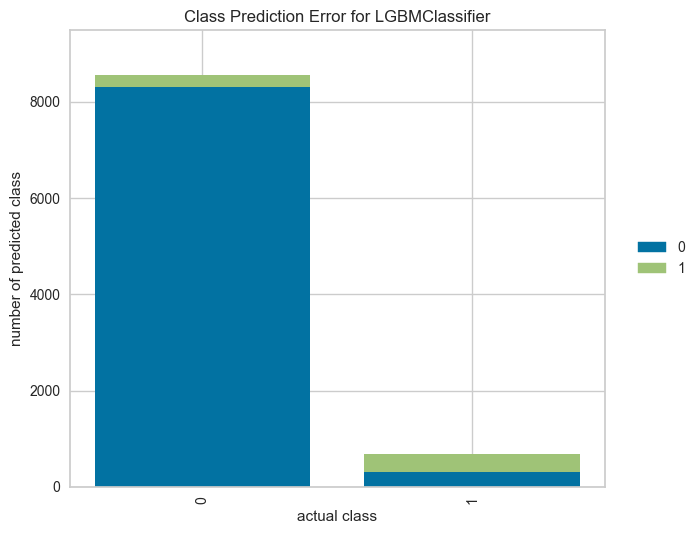

In [81]:
plot_model(lgbm, plot='error')

5.7 Model Interpretability

In [82]:
#pip install shap

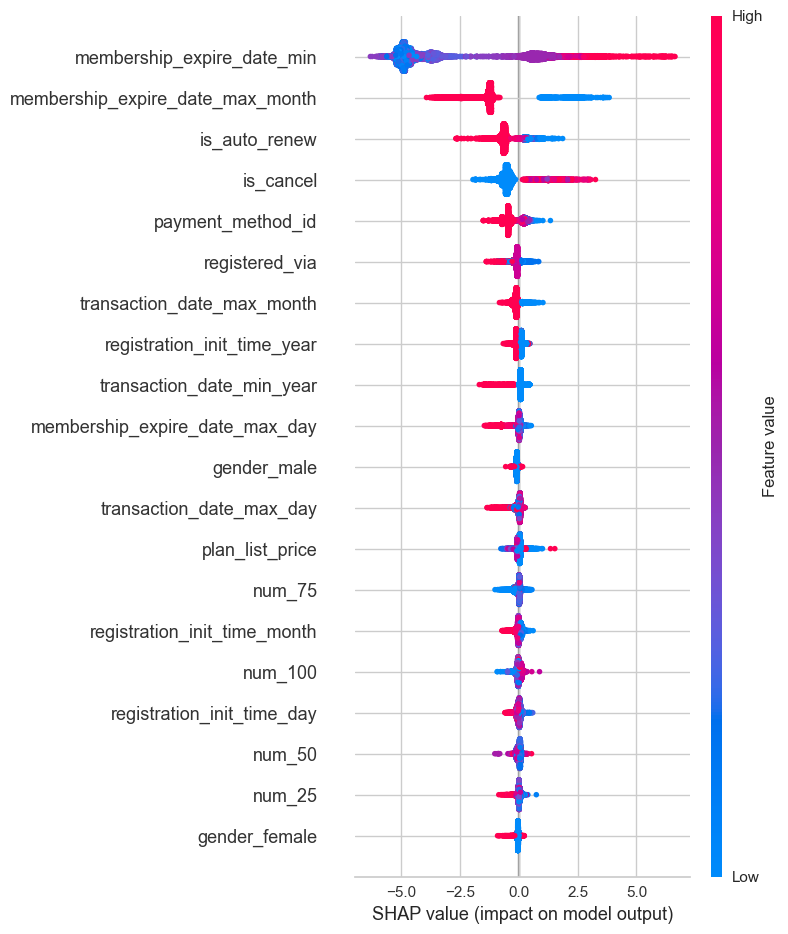

In [83]:
# interpret model
interpret_model(lgbm)

In [84]:
interpret_model(lgbm,plot='correlation',feature='is_cancel')

IndexError: index 18 is out of bounds for axis 1 with size 1

In [85]:
interpret_model(lgbm,plot='reason',observation=0) # index of observation in test data

IndexError: invalid index to scalar variable.

In [1]:
#pip install interpret

In [86]:
interpret_model(lgbm,plot='msa')

5.8 Model Evaluation

In [87]:
# Convert to datetime
for col in date_columns:
    data_unseen[col] = pd.to_datetime(data_unseen[col])
predict_model(lgbm, data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9358,0.9354,0.5842,0.4876,0.5315,0.4974,0.4997


,msno,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn,prediction_label,prediction_score
0,ZHEHMtZ+/2XKdCEA4ZUzjO8aFnwJ72XFu5WGFL/jUAU=,12,21,male,9,2016-04-19,37.000000,30.000000,149.000000,149.000000,...,2.024841,0.630524,0.400991,0.581542,3.222693,3.299442,8.846843,0,0,0.9855
1,jAjj14OxSk4XeV6T8fhQw2F0vKZ2aE886DrKa8t5tno=,1,0,others,7,2016-01-16,41.000000,30.000000,99.000000,99.000000,...,0.000000,0.000000,0.077016,0.000000,2.705719,2.518539,8.216146,0,0,0.9997
2,iaVaviN4lUCUPdjLmW4I2imcXHjgh0JnKBHyyqul4g4=,1,0,others,4,2015-12-24,36.000000,30.000000,174.545456,174.545456,...,1.986603,0.586782,0.286122,0.656199,2.975163,2.488776,8.693685,0,0,0.9992
3,jGSze9adjTwMhEhJEImsXGK+1iIaOpHDoiOuvBUIRy8=,14,24,female,9,2015-01-16,36.740742,30.148148,157.037033,157.037033,...,0.892898,0.296717,0.171844,0.267226,2.444995,2.356606,8.093060,0,0,0.9641
4,Xz9NaHBfJSjUJYHAk6ey0Rel/94Oiq42EoIN6EcHNW0=,4,0,others,4,2016-05-06,38.000000,30.000000,149.000000,149.000000,...,2.220674,1.026218,0.542796,1.090072,2.265273,2.981720,8.338086,1,0,0.9993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,5FnfrlQ6qh6wSN8K2oMy7RZZtgGVfuZYcR8raihoNvw=,14,17,male,9,2015-06-16,28.000000,58.750000,293.750000,293.750000,...,1.668997,0.560466,0.418600,0.313940,3.293501,3.301598,8.926649,1,1,0.8319
1616,a/Bv/ecWC6fDy1Nf4EXcva3qvswfllzUkfuuqvAURV4=,4,24,male,9,2015-04-07,37.937500,28.125000,139.687500,149.000000,...,1.319649,0.217343,0.112360,0.148224,2.304367,2.588636,7.858624,0,0,0.8168
1617,mk/Ym2KnwLISIR5XWv4BaG4zDOK04txFEJoEdBgyIEE=,17,22,female,4,2016-01-12,38.555557,27.444445,132.444443,115.888885,...,0.575646,0.000000,0.000000,0.000000,1.658000,1.589027,6.665039,0,0,0.9466
1618,LqP/D/ABy78VPr+eKnFQjWiQyq83fOIr16cR7zIQxcI=,1,0,others,9,2015-12-16,36.000000,30.000000,169.411758,169.411758,...,1.573441,0.818422,0.458214,0.558693,3.676674,3.471627,9.347936,1,0,0.9391
